In [91]:
#Lectura de datos  
import pandas as pd

#Predicción para la hoja Chevrolet
#Leer datos desde una hoja de excel y seleccionando la hoja
df = pd.read_excel('C:/Users/Daniel/Documents/Axa Colpatria/Guía fasecolda/Database_marcas.xlsx', sheet_name='Otros_gamma_alta')

In [92]:
#Organización de la base

df = df.transpose()

In [93]:
df = df[1:]

#Cambiar el formato a fecha del indice
df.index = pd.to_datetime(df.index, format='%Y%m')

In [94]:
#Asignarle a la fecha 2021-07-01 los valores promedio de las demás fechas
df.loc['2021-07-01'] = df.mean()


In [95]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [96]:
# Definir las fechas de inicio y final para las predicciones
start_pred = '2022-04-01'
end_pred = '2023-01-01'

In [97]:
# Crear un DataFrame vacío para almacenar las predicciones
predictions_df = pd.DataFrame()


In [98]:
# Iterar sobre cada columna del DataFrame 'data'
for column in df.columns:
    # Seleccionar una serie de tiempo
    dataframe = df[column]

    dataset = dataframe.values
    dataset = dataset.astype('float32')

    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset.reshape(-1, 1))

    # convert an array of values into a dataset matrix
    def create_dataset(dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)

    # train the model on the whole dataset
    look_back = 10  # Number of previous time steps to consider
    trainX, trainY = create_dataset(dataset, look_back)
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

    # Predict the next 9 values
    last_sequence = dataset[-look_back:].reshape((1, 1, look_back))
    predictions = []
    for _ in range(9):
        predicted_value = model.predict(last_sequence)
        predictions.append(predicted_value[0, 0])
        last_sequence = np.roll(last_sequence, -1, axis=2)
        last_sequence[0, 0, -1] = predicted_value

    # Inverse transform the predictions
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)

    # Create a DataFrame of the predictions
    predictions = pd.DataFrame(predictions, index=pd.date_range(start=start_pred, periods=9, freq='MS'), columns=[column])

    # Append the predictions to the DataFrame 'predictions_df'
    predictions_df = pd.concat([predictions_df, predictions], axis=1)




Epoch 1/100
40/40 - 6s - loss: 0.3112 - 6s/epoch - 158ms/step
Epoch 2/100
40/40 - 0s - loss: 0.1259 - 143ms/epoch - 4ms/step
Epoch 3/100
40/40 - 0s - loss: 0.0344 - 161ms/epoch - 4ms/step
Epoch 4/100
40/40 - 0s - loss: 0.0086 - 159ms/epoch - 4ms/step
Epoch 5/100
40/40 - 0s - loss: 0.0051 - 138ms/epoch - 3ms/step
Epoch 6/100
40/40 - 0s - loss: 0.0049 - 129ms/epoch - 3ms/step
Epoch 7/100
40/40 - 0s - loss: 0.0049 - 129ms/epoch - 3ms/step
Epoch 8/100
40/40 - 0s - loss: 0.0049 - 132ms/epoch - 3ms/step
Epoch 9/100
40/40 - 0s - loss: 0.0049 - 126ms/epoch - 3ms/step
Epoch 10/100
40/40 - 0s - loss: 0.0049 - 144ms/epoch - 4ms/step
Epoch 11/100
40/40 - 0s - loss: 0.0049 - 161ms/epoch - 4ms/step
Epoch 12/100
40/40 - 0s - loss: 0.0049 - 125ms/epoch - 3ms/step
Epoch 13/100
40/40 - 0s - loss: 0.0049 - 125ms/epoch - 3ms/step
Epoch 14/100
40/40 - 0s - loss: 0.0049 - 128ms/epoch - 3ms/step
Epoch 15/100
40/40 - 0s - loss: 0.0049 - 126ms/epoch - 3ms/step
Epoch 16/100
40/40 - 0s - loss: 0.0050 - 126ms/epo

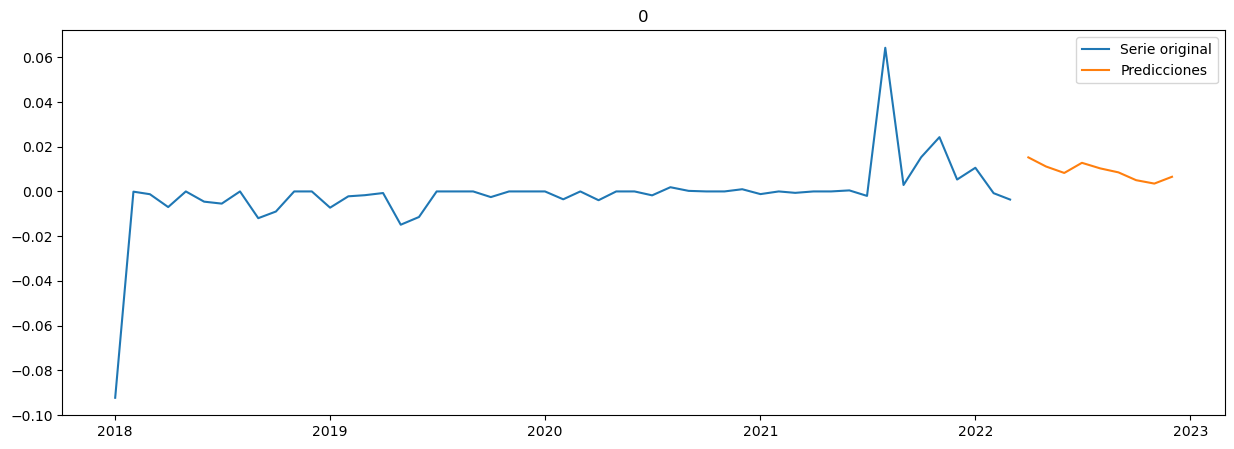

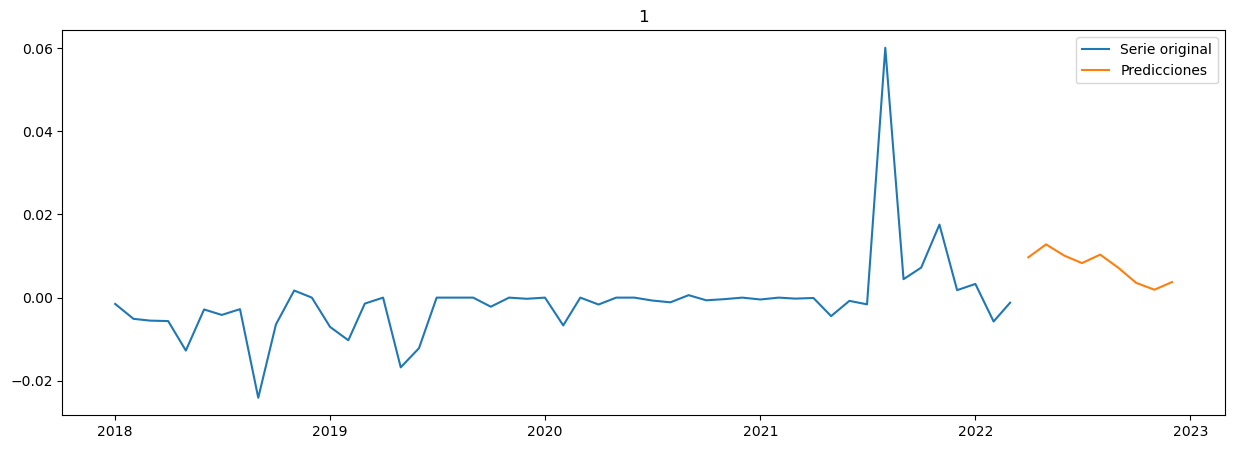

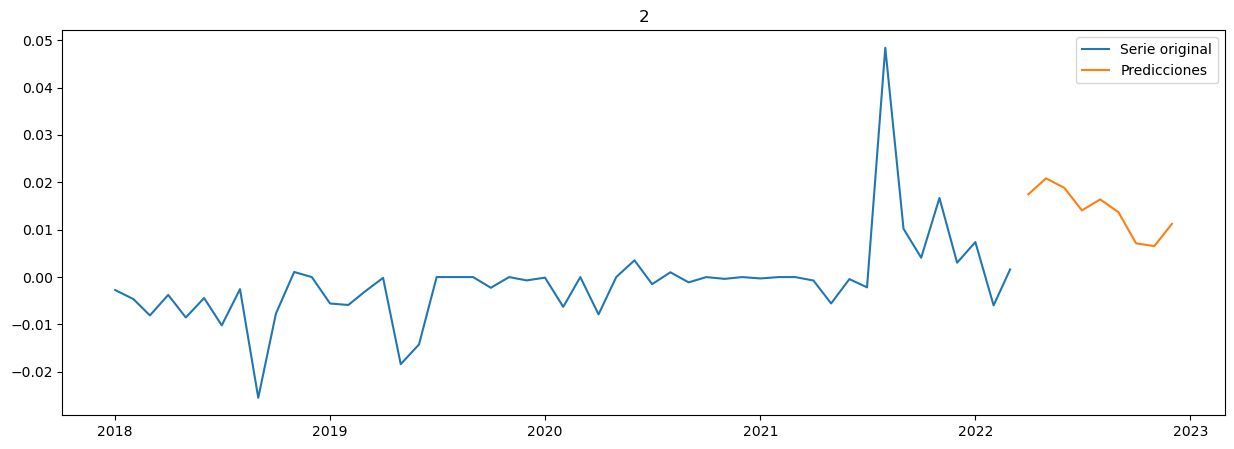

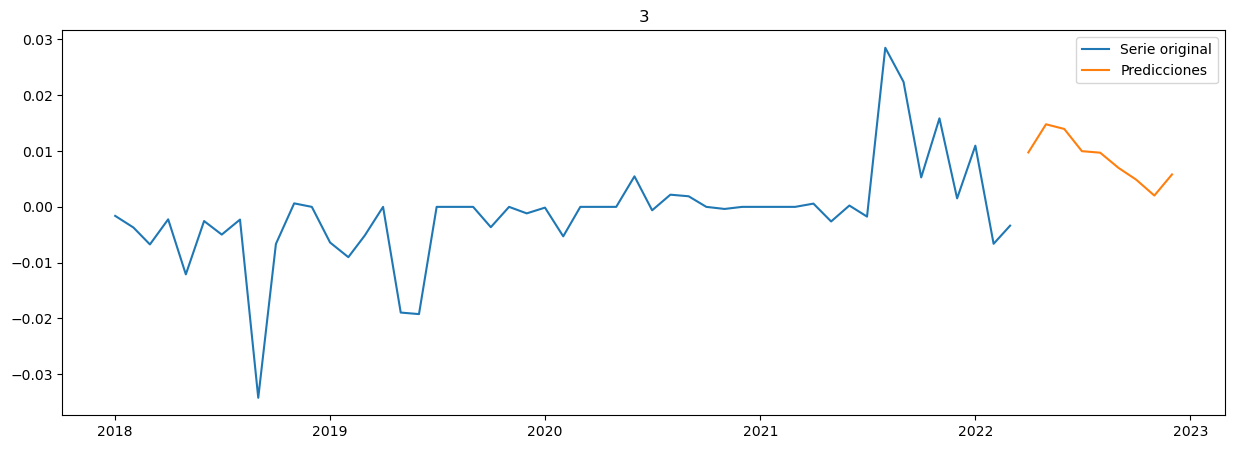

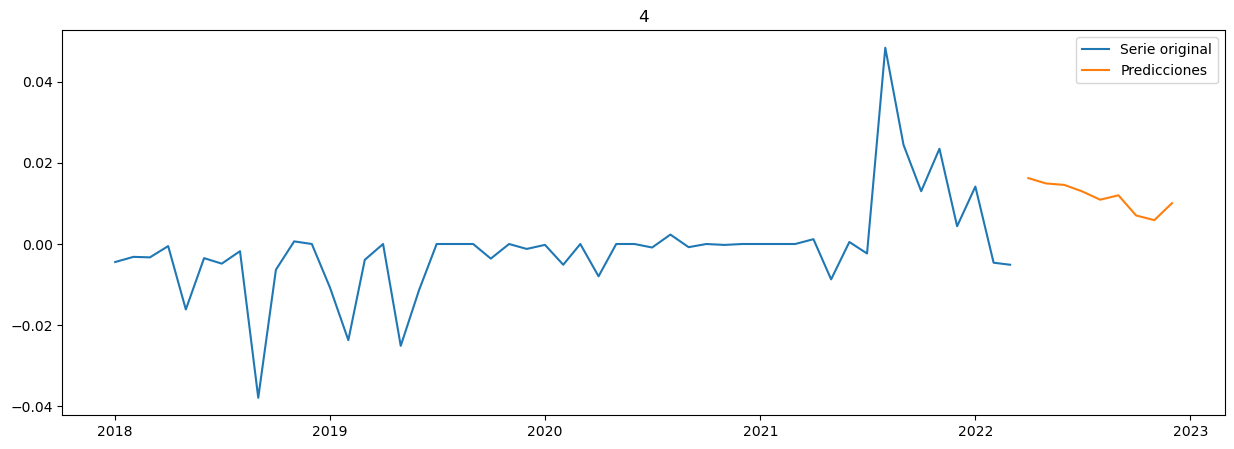

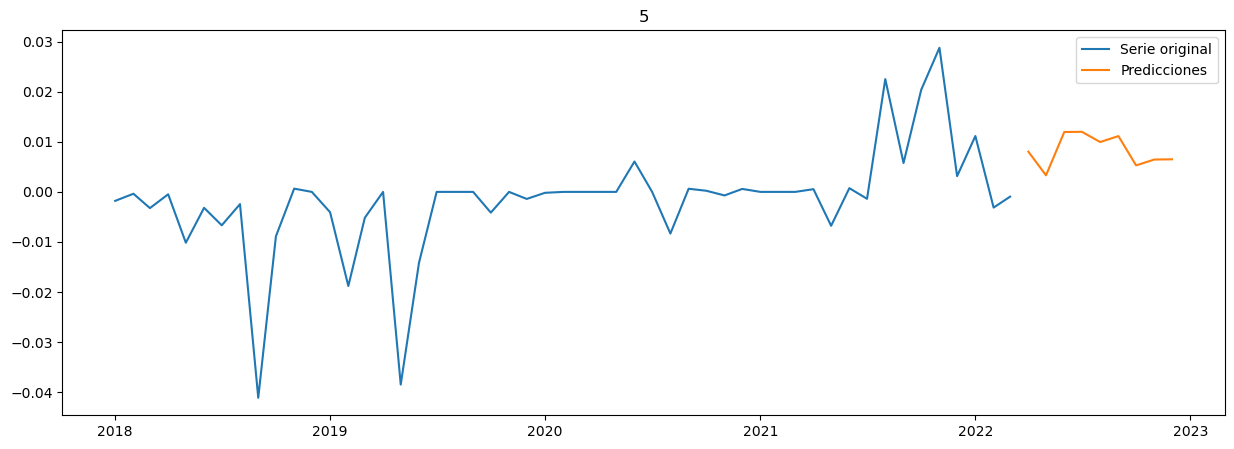

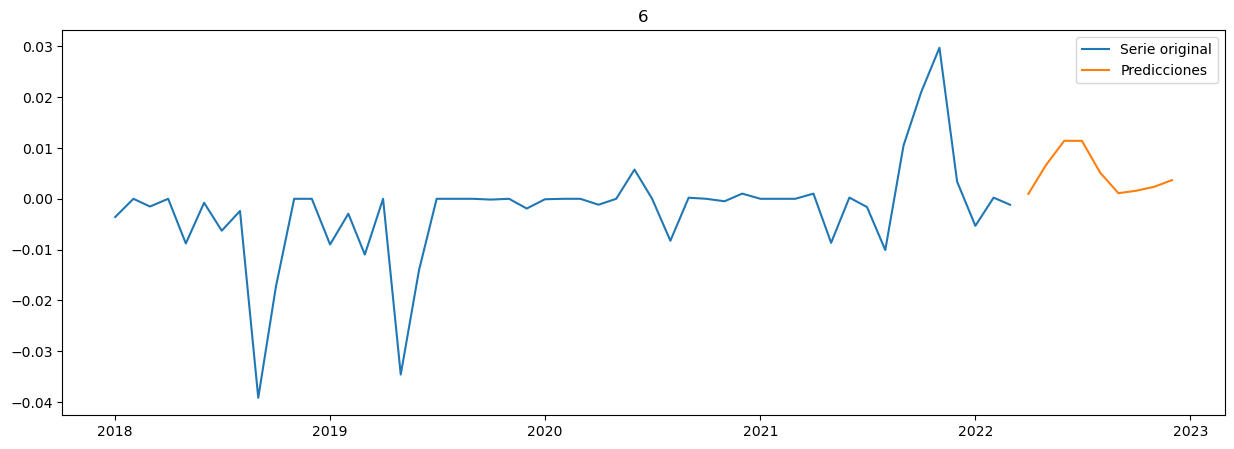

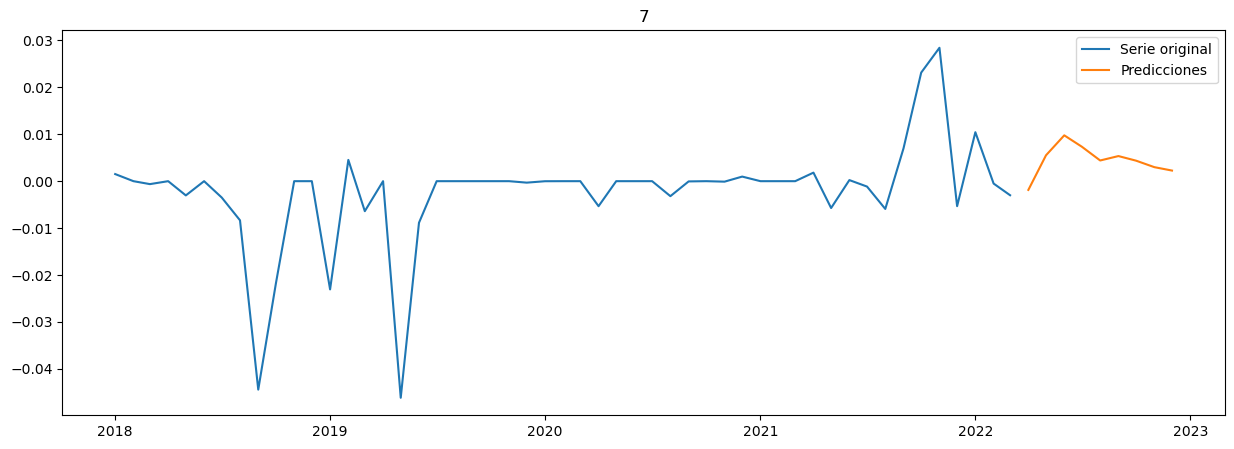

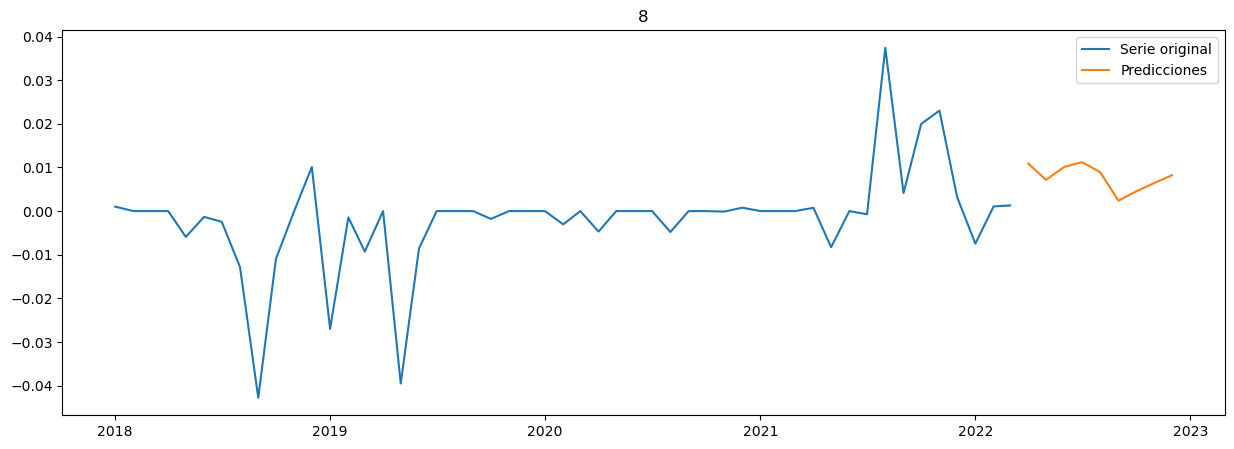

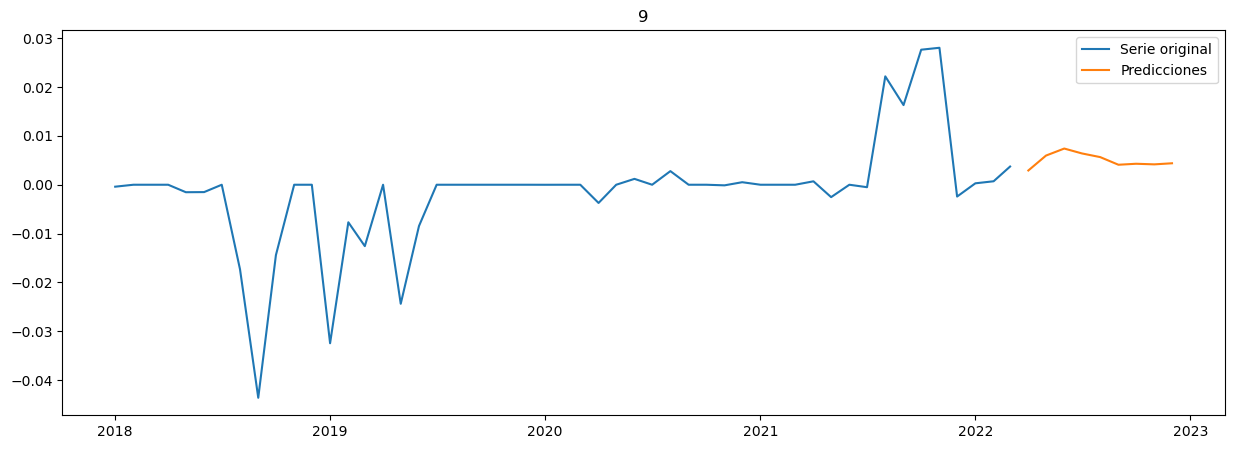

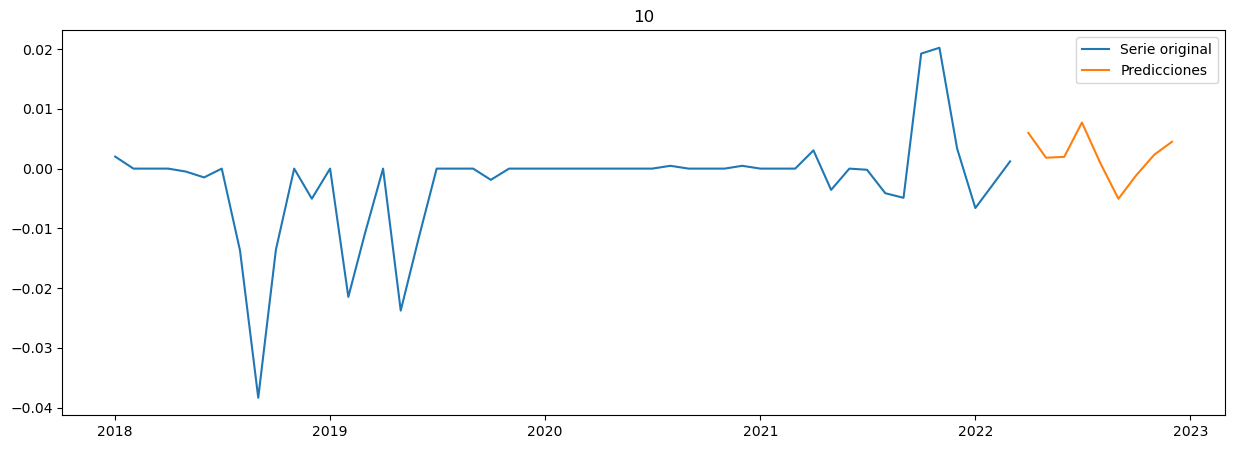

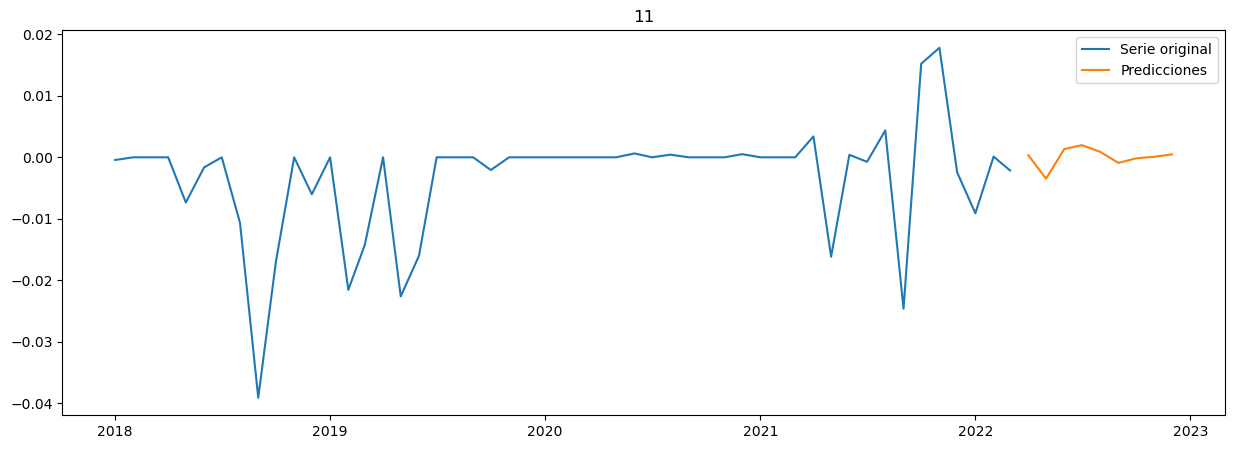

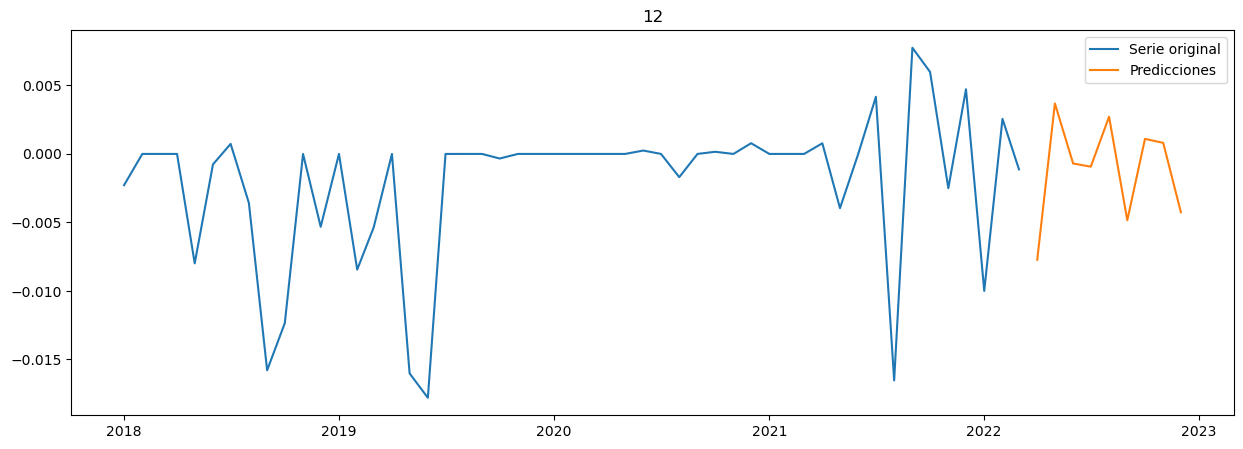

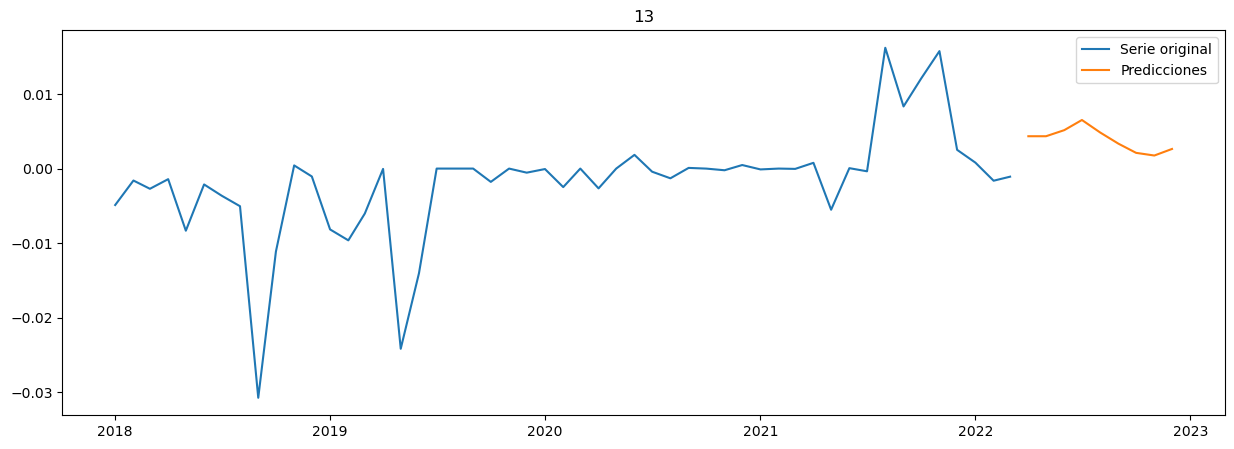

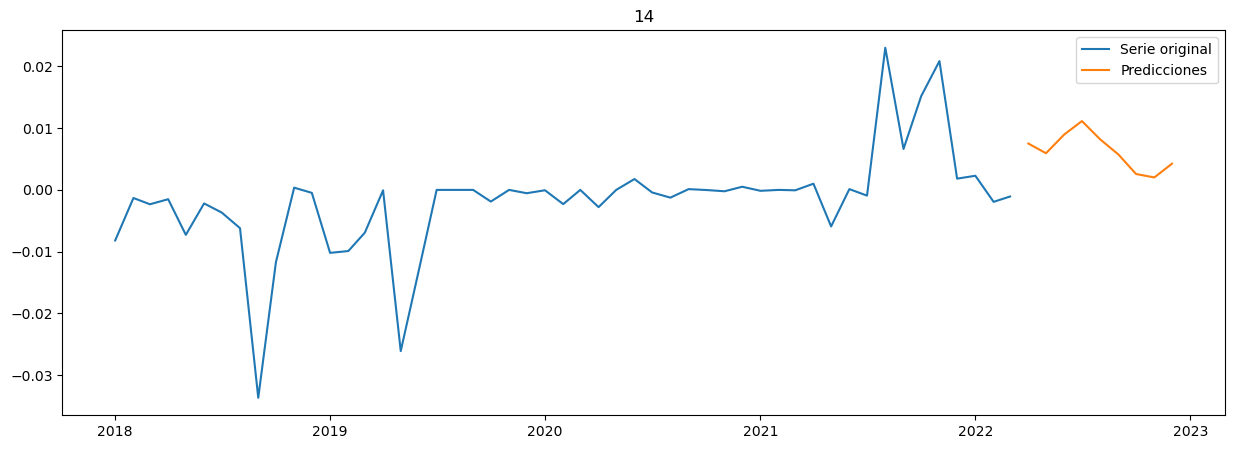

In [99]:
# Graficar las predicciones
for column in df.columns:
    plt.figure(figsize=(15,5))
    plt.plot(df[column], label='Serie original')
    plt.plot(predictions_df[column], label='Predicciones')
    plt.legend()
    plt.title(column)
    plt.show()

In [100]:
predictions_df.to_excel('C:/Users/Daniel/Documents/Axa Colpatria/Guía fasecolda/Predicciones_Otros_gamma_alta.xlsx')